In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random


import torch

# For tensorboard
import time
from torch.utils.tensorboard import SummaryWriter


In [2]:
# time and sequence LSTM and try

### Formulating question
can with only 40 percent of the steps - > you can predict if the question will be answered correctly? (midway feedback)

`input : |0.4*sequence |0.4*time|`<br>
`output : correct or not`

### Columns present - 
PIN | case_assigned_to | start_time | end_time | time_spent | steps_EDA_1 | time_spent_EDA1 | .... | result

In [3]:
df = pd.read_excel('../data/timestamp_data.xlsx')

In [4]:
# Drop unwanted column because of excel
df.drop('Unnamed: 0', 1, inplace = True)

In [5]:
df.head(2)

,PIN,Solution_points,case_assigned_to,timestamp,EDA,date,day,month,year,dayofweek,week,time,hour,minute,seconds,diff_timestamp,diff_minutes,diff_seconds
0,AEOGCR7,1,1,2018-05-08 15:12:22,1,2018-05-08,8,5,2018,1,19,15:12:22,15,12,22,0.000000,0,0
1,AEOGCR7,1,1,2018-05-08 15:12:26,1,2018-05-08,8,5,2018,1,19,15:12:26,15,12,26,0.000046,0,4


In [6]:
drop_cols = ['time','date','day','month','year','dayofweek','week','hour','minute','seconds','diff_timestamp','diff_minutes']
df.drop(drop_cols, 1, inplace = True)

In [7]:
df.head()

,PIN,Solution_points,case_assigned_to,timestamp,EDA,diff_seconds
0,AEOGCR7,1,1,2018-05-08 15:12:22,1,0
1,AEOGCR7,1,1,2018-05-08 15:12:26,1,4
2,AEOGCR7,1,1,2018-05-08 15:12:52,1,26
3,AEOGCR7,1,1,2018-05-08 15:13:50,1,58
4,AEOGCR7,1,1,2018-05-08 15:14:05,1,15


In [8]:
pin = []
case_assigned = []
seq = []
time_diff = []

for i in (df.groupby(['PIN','case_assigned_to'])):
    #print(i[0][0], i[0][1], i[1]['EDA'])
    pin.append(i[0][0])
    case_assigned.append(i[0][1])
    seq.append(i[1]['EDA'].tolist())
    time_diff.append(i[1]['diff_seconds'].tolist())

In [9]:
# finding the max sequence length 330 and 23, avg = 78 we take 30 we cover 455
x = []

for i in seq:
    x.append(len(i))
    
import math

max(x), min(x), sum(x)/len(x)

(330, 23, 78.47741935483872)

In [10]:
df_seq = pd.DataFrame({'PIN': pin, 'case_assigned_to': case_assigned, 'Sequence': seq, 'time_diff': time_diff})

In [11]:
df2 = pd.read_excel("../data/wide_data.xlsx")

In [12]:
# Drop unwanted column because of excel
df2.drop('Unnamed: 0', 1, inplace = True)

In [13]:
df2.shape

(465, 18)

In [14]:
new_df = pd.merge(df2, df_seq,how='left', 
                     left_on=('PIN','case_assigned_to'), right_on=('PIN','case_assigned_to'))

In [15]:
new_df.columns

Index(['PIN', 'case_assigned_to', 'start_time', 'stop_time', 'time_spent',
       'steps_EDA_0', 'steps_EDA_1', 'steps_EDA_2', 'steps_EDA_3',
       'steps_EDA_4', 'steps_EDA_5', 'timespent_EDA_0', 'timespent_EDA_1',
       'timespent_EDA_2', 'timespent_EDA_3', 'timespent_EDA_4',
       'timespent_EDA_5', 'result', 'Sequence', 'time_diff'],
      dtype='object')

In [16]:
# new_df['Time_taken_min'] = (new_df['stop_time']-new_df['start_time']).apply(lambda x: x/np.timedelta64(1, 's')).fillna(0).astype('int64')

In [17]:
new_df2 = new_df.loc[:,['Sequence','time_diff', 'result']]

In [18]:
# (new_df2[new_df2['Time_taken_min']>3000])


In [19]:
# new_df2.drop(index = [428,461], axis = 0, inplace = True)

In [20]:
# new_df2 = new_df2[new_df2['Sequence'].map(lambda x: len(x) >= 30)]

In [21]:
# new_df2['Sequence'].map(lambda x: len(x)).max()

In [22]:
new_df2.head(2)

,Sequence,time_diff,result
0,"[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, ...","[0, 4, 26, 58, 15, 146, 21, 3, 8, 2, 16, 4, 17...",1
1,"[1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, ...","[0, 104, 10, 253, 58, 29, 5, 2, 6, 9, 3, 7, 4,...",1


In [23]:
type(new_df2.Sequence),type(new_df2.Sequence[0])

(pandas.core.series.Series, list)

In [24]:
# # determining the name of the file
# file_name = 'sequence_data_2.xlsx'
  
# # saving the excel
# new_df2.to_excel(file_name)

### Splitting the DataFrame into Train Test

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X = new_df2

# Splitting the dataframe into 80 percent for train and val, 20 percent for the test
X_train,X_test = train_test_split(X.index,test_size=0.2, random_state=87)

In [27]:
X.iloc[X_test].result.value_counts()
# print(55/(55+38))

1    55
0    38
Name: result, dtype: int64

In [28]:
X.iloc[X_train].result.value_counts()
# print(252/(252+120))

1    252
0    120
Name: result, dtype: int64

## Create a RNN 

In [29]:
# Create Dataset
class Simulated_dataset(torch.utils.data.Dataset):
    
    def __init__(self, df, max_seq_length, min_seq_len, seq_percent, is_test):
        
        self.df = df
        self.seq = []
        self.seq_len = []
        self.seq_time = []
        self.seq_percent = (seq_percent/100)
        self.is_test = is_test
        self.min_seq_len = min_seq_len
        
        for i in range(df.shape[0]):
            
            if is_test == 0:
                random.seed(10)
                self.seq_percent = random.random()
                val, seqtime, seqlen = self.add_padding(df.iloc[i].Sequence, df.iloc[i].time_diff, max_seq_length, self.seq_percent, self.is_test )
                self.seq.append(val)
                self.seq_time.append(seqtime)
                self.seq_len.append(seqlen)
                
            else:
                val, seqtime, seqlen = self.add_padding(df.iloc[i].Sequence, df.iloc[i].time_diff, max_seq_length, self.seq_percent, self.is_test )
                self.seq.append(val)
                self.seq_time.append(seqtime)
                self.seq_len.append(seqlen) 
                
            
                
    def add_padding(self, seq, time, padding_len, seq_percent, is_test):
                
        pad_token = 6
        
        if is_test == 1:

            # changing seq percent for test       
            seq_len = len(seq)
            seq_len = int(seq_percent*seq_len)

            seq = seq[:seq_len]   
            time = seq[:seq_len]

            deficit = padding_len - seq_len

            if deficit < 0:
                seq = seq[:padding_len]
                time = time[:padding_len]
            else:
                seq.extend([pad_token]* deficit)
                time.extend([pad_token]* deficit)

            return seq, time, seq_len
        
        else: 
        
            # For training keeping seq to 100 percent               
            seq_percent = 1
            seq_len = len(seq)
            seq_len = int(seq_percent*seq_len)
            
            seq = seq[:seq_len]   
            time = seq[:seq_len]

            deficit = padding_len - seq_len

            if deficit < 0:
                seq = seq[:padding_len]
                time = time[:padding_len]
            else:
                seq.extend([pad_token]* deficit)
                time.extend([pad_token]* deficit)

            return seq, time, seq_len
            
        
    def __len__(self):
        return self.df.shape[0]
    
    
    def __getitem__(self, sample_id):
        
        sample_dict = dict()
        
        sequence = torch.tensor(self.seq[sample_id], dtype = torch.int32)
#         sequence = torch.reshape(sequence, (sequence.shape[0], 1))
        sample_dict["sequence"] = sequence
        
        time = torch.tensor(self.seq_time[sample_id], dtype = torch.float32)
        time = torch.reshape(time, (time.shape[0], 1))
        sample_dict["time_diff"] = time
        
        sample_dict["seq_len"] = torch.tensor(self.seq_len[sample_id]).long()      
                
        sample_dict['labels'] = torch.tensor(self.df.iloc[sample_id].result)
        
        return sample_dict

In [30]:
hparams = {
    
    'batch_size' : 20,
    'max_length': 330,
    'min_length': 10
   
}

In [31]:
Train_dataset = Simulated_dataset(X.iloc[X_train], hparams['max_length'], hparams['min_length'], 100, 0)

In [32]:
# (Train_dataset[8]['seq_len'])

In [33]:
# Splitting the dataset in train and val into 75, 25

train_len, val_len = int(0.75*len(Train_dataset)), int(0.25*len(Train_dataset))
train_dataset, val_dataset = torch.utils.data.random_split(Train_dataset, [train_len,val_len],generator=torch.Generator().manual_seed(88))


In [34]:
len(train_dataset), len(val_dataset)

(279, 93)

In [35]:
# Getting data into the dataloader

train_data = torch.utils.data.DataLoader(train_dataset, hparams["batch_size"], shuffle = True)
val_data = torch.utils.data.DataLoader(val_dataset, hparams["batch_size"], shuffle = True)


In [36]:
### Your code goes here ####
import torch.nn as nn

class Classification_model(nn.Module):
    
    def __init__(self, batch_size, emd_dim, lstm_layers, hidden_dim, max_length):
        
        super(Classification_model, self).__init__()
        
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.LSTM_layers = lstm_layers
        self.max_len = max_length
        self.emb_dim = emd_dim

        self.dropout = nn.Dropout(0.5)
        self.embedding = nn.Embedding(7, emd_dim, padding_idx=6)
        self.lstm = nn.LSTM(input_size=self.emb_dim+1, hidden_size=self.hidden_dim, num_layers=self.LSTM_layers, batch_first=True)
        self.fc1 = nn.Linear(in_features=self.hidden_dim, out_features=48)
        self.fc2 = nn.Linear(in_features = 48, out_features = 2)
        self.softmax = nn.Softmax(1)
        
    def forward(self, x):
        
        # LSTM initialization 
        seq = x['sequence']
        seq_len = x['seq_len']
        time = x['time_diff']
            
        # pass through the embedding layer
        out = self.embedding(seq)    
    
        # Initializing h and c for LSTM Seq
        h = torch.zeros((self.LSTM_layers, seq.size(0), self.hidden_dim))
        c = torch.zeros((self.LSTM_layers, seq.size(0), self.hidden_dim))

        # stack sequence and time
        out = torch.cat((out, time), dim=2)
        
        lstm_input_seq = torch.nn.utils.rnn.pack_padded_sequence(out, seq_len.tolist(), batch_first=True, enforce_sorted=False)
        out_seq, (hidden, cell) = self.lstm(lstm_input_seq, (h,c))
        out_seq,_ = torch.nn.utils.rnn.pad_packed_sequence(out_seq, batch_first=True)
        out_seq = out_seq[range(len(out_seq)), seq_len - 1, :self.hidden_dim]
        out_seq = self.dropout(out_seq)
      
        ####################################################
        
        out = self.fc1(out_seq)
        out = torch.relu_(out)
        out = self.fc2(out)
        out = self.softmax(out)
        
        return out


In [37]:
hparams = {
    
    'epochs' : 50,
    'learning_rate' : 1e-3,
    'batch_size' : 20,
    'emd_dim': 150,
    'lstm_layers' : 1,
    'hidden_dim' : 150,
    'max_length': 330,
    'min_length': 10
   
}

In [38]:
model = Classification_model(hparams["batch_size"], hparams["emd_dim"], hparams["lstm_layers"], hparams["hidden_dim"], hparams["max_length"] )

In [39]:
model

Classification_model(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(7, 150, padding_idx=6)
  (lstm): LSTM(151, 150, batch_first=True)
  (fc1): Linear(in_features=150, out_features=48, bias=True)
  (fc2): Linear(in_features=48, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [40]:
# # # Checking the shape of the dataloader batch

# # model_test = Classification_model(hparams["batch_size"], hparams["lstm_layers"], hparams["hidden_dim"], hparams["max_length"] )

# for i, batch in enumerate(train_data):
    
    
#     batch['seq_len'] = (batch['seq_len']*np.random.uniform(size=(20,))).int().clip(hparams['min_length'])
#     print(batch['seq_len'])
#     break
    
#     #input to the model is dictionary
#     # for j in 
#     percent = random.random()
#     print("input:", (batch["sequence"][0][:20]))
    
#     #output from the model shape
# #     y_pred = model_test(batch)
# #     print("output:", y_pred)
#     break
    

In [41]:
# np.random.uniform(size=(20,))

In [42]:
## Training

class Model_trainer:

    def __init__(self, hparams, model, train_data, val_data):
        
        self.hparams = hparams
        self.batch_size = hparams["batch_size"]
        self.train_data = train_data
        self.val_data = val_data
        
        # pass all the training arguments
        self.model = model
        
        # Logging the history and displaying graph later
        self.train_loss_history = [] 
        self.train_acc_history = [] 
        self.val_acc_history = []
        self.val_loss_history = []
        
        # Create Tensorboard - writer
        self.writer = self.initialize_tensorboard()

    def train(self):

        optimizer = torch.optim.Adam(self.model.parameters(), lr=hparams["learning_rate"])
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(self.hparams["epochs"]):

            train_predictions = []
            train_labels = []
            running_loss = 0.0
            correct = 0.0
            total = 0
            
            self.model.train()

            for i, batch in enumerate(self.train_data):
              
                optimizer.zero_grad()
                y = batch["labels"]
                
                #passing variable seq length to the model
                batch['seq_len'] = (batch['seq_len']*np.random.uniform(size=batch['seq_len'].shape)).long().clip(hparams['min_length'])
    
                y_pred = self.model(batch)
                
                loss = criterion(y_pred, y)
                
                loss.backward()
                optimizer.step()
                                
                # Accumulate the loss and calculate the accuracy of predictions
                running_loss += loss.item()
                
                #convert output probabilities of each class to a singular class prediction
                _, preds = torch.max(y_pred, 1) 
            
                correct += preds.eq(y).sum().item()
                total += y.size(0)
                
                # Print the statistics every 10 mini-batch
                if  i % 10 == 9:    
                    running_loss /= 10
                    correct /= total
                    print("[Epoch %d, Iteration %5d] training loss: %.3f training acc: %.2f %%" % (epoch+1, i+1, running_loss, 100*correct))
                    self.train_loss_history.append(running_loss)
                    self.train_acc_history.append(correct)

                    
                    # log the running loss on tensorboard for Traininig data
                    self.writer.add_scalar('Training loss',running_loss / 50,epoch * len(self.train_data) + i)
                    self.writer.add_scalar('Training Accuracy', correct*100, epoch * len(self.train_data) + i)

                    running_loss = 0.0
                    correct = 0.0
                    total = 0
                        
            val_loss, val_accuracy = self.evaluation(criterion)            
            self.val_acc_history.append(val_accuracy)
            self.val_loss_history.append(val_loss)
            print("------------[Epoch: %d] Val Loss: %.5f Val accuracy: %.2f %%------------" % (epoch+1, val_loss, val_accuracy*100))

            # log the accuracy on tensorboard for Validation data
            self.writer.add_scalar('Validation Accuracy', val_accuracy*100, epoch * len(self.train_data) + i)
            self.writer.add_scalar('Validation Loss', val_loss, epoch * len(self.train_data) + i)

        self.writer.add_hparams(self.hparams, {'Vald Accuracy': self.val_acc_history[-1]*100, 'Train Accuracy': self.train_acc_history[-1]*100 })
        self.writer.close()

        
    def evaluation(self, criterion):
        
        ## evaluating on the validation data 
        running_loss = 0.0
        correct = 0
        total = 0
        
        
        self.model.eval()
        with torch.no_grad():
            for i , batch in enumerate(self.val_data):
               
                y = batch["labels"]
                static_seq_len = batch["seq_len"]        
                
                for j in range(10, 101, 10):
                    
                    batch["seq_len"] = static_seq_len 
                    batch['seq_len'] = (batch['seq_len']*(j/100)).long().clip(hparams['min_length'])

                    y_pred = self.model(batch)
                
                    loss = criterion(y_pred, y)
                    running_loss += loss.item()

                    _, val_preds = torch.max(y_pred, 1)

                    correct += val_preds.eq(y).sum().item()
                    total += y.size(0)
        
            val_accuracy = correct/total
            val_loss = running_loss/total

        return val_loss, val_accuracy
    
    def visualize_train(self):
        
        """ Visualizing the training data """
        plt.plot(self.train_acc_history)
        plt.plot(self.train_loss_history)
        plt.title("Questions Dataset")
        plt.xlabel('iteration')
        plt.ylabel('train acc/ train loss')
        plt.legend(['Train Acc', 'Train Loss'])
        plt.show()
        
    def visualize_val(self):
        
        """ Visualizing the training data """
        plt.plot(self.val_acc_history)
        plt.plot(self.val_loss_history)
        plt.title("Questions Dataset")
        plt.xlabel('iteration')
        plt.ylabel('Val Acc / Val Loss')
        plt.legend(['Val Acc', 'Val Loss'])
        plt.show()
        
        
    def initialize_tensorboard(self):
        
        current_time = time.strftime("%d%m_%Hh_%Mm")
        writer = SummaryWriter('runs/Simulated_dataset_variable_Percent/'+current_time)
        
        return writer

In [43]:
Train = Model_trainer(hparams, model, train_data, val_data)
Train.train()

[Epoch 1, Iteration    10] training loss: 0.649 training acc: 68.50 %
------------[Epoch: 1] Val Loss: 0.03502 Val accuracy: 64.52 %------------
[Epoch 2, Iteration    10] training loss: 0.637 training acc: 68.00 %
------------[Epoch: 2] Val Loss: 0.03517 Val accuracy: 64.52 %------------
[Epoch 3, Iteration    10] training loss: 0.614 training acc: 69.00 %
------------[Epoch: 3] Val Loss: 0.03509 Val accuracy: 64.52 %------------
[Epoch 4, Iteration    10] training loss: 0.613 training acc: 70.00 %
------------[Epoch: 4] Val Loss: 0.03512 Val accuracy: 64.52 %------------
[Epoch 5, Iteration    10] training loss: 0.607 training acc: 69.50 %
------------[Epoch: 5] Val Loss: 0.03504 Val accuracy: 64.52 %------------
[Epoch 6, Iteration    10] training loss: 0.589 training acc: 72.00 %
------------[Epoch: 6] Val Loss: 0.03498 Val accuracy: 64.52 %------------
[Epoch 7, Iteration    10] training loss: 0.647 training acc: 64.50 %
------------[Epoch: 7] Val Loss: 0.03472 Val accuracy: 64.52

### Visualize the entire validation data on different percentage of sequence length



In [74]:
seq_percent_to_consider = list(range(5,101,5))

val_seq_percent = []
val_accuracy = []

def run_val(seq_percent_to_consider):
    
    ## evaluating on the validation data 
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():        
        for j in range(10, 101, 5):
            for i , batch in enumerate(val_data):
                y = batch["labels"]
                batch['seq_len'] = (batch['seq_len']*(j/100)).long().clip(hparams['min_length'])

                y_pred = model(batch)

                _, val_preds = torch.max(y_pred, 1)

                correct += val_preds.eq(y).sum().item()
                total += y.size(0)

            accuracy = correct/total

            val_seq_percent.append(j)
            val_accuracy.append(accuracy)
        
run_val(seq_percent_to_consider)

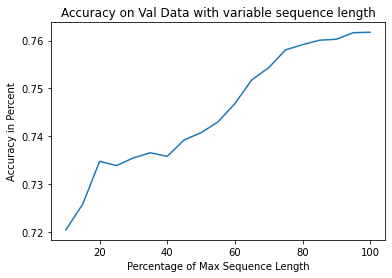

In [75]:
plt.plot(val_seq_percent,val_accuracy)
plt.title('Accuracy on Val Data with variable sequence length')
plt.xlabel('Percentage of Max Sequence Length')
plt.ylabel('Accuracy in Percent')
plt.show()

## On test Data

In [46]:
class test_trainer:

    def __init__(self, model, test_data):

        self.test_data = test_data
        self.model = model

    def evaluate(self):
              
        test_accuracy = self.test_evaluation()
        print("Test accuracy: %.5f" % (test_accuracy*100))
        return test_accuracy
            
    def test_evaluation(self):

        ## evaluating on the validation data 
        correct = 0
        total = 0
        
        self.model.eval()
        with torch.no_grad():
            
            for i, batch in enumerate(self.test_data):
                y = batch["labels"]
                y_pred = self.model(batch)

                _, test_pred = torch.max(y_pred, 1) 
#                 print("pred:",test_pred,"\nlabels:",y)
                correct += test_pred.eq(y).sum().item()
                total += y.size(0)
            
            test_accuracy = correct/total

            return test_accuracy

### Creating a Test Dataset and dataloader

In [76]:
seq_percent_to_consider = list(range(10,101,5))

In [80]:
seq_percent = []
accuracy = []

def run_test(seq_percent_to_consider):
    
    batch_size = 10
    
    for i in seq_percent_to_consider:
        
        max_len = int(330*(i/100))
        print("Percent considered:",i)
        Test_dataset = Simulated_dataset(X.iloc[X_test], max_len, hparams['min_length'], i, 1)
#         print("Max Seq Length:",len(Test_dataset[0]['sequence']))
        test_data = torch.utils.data.DataLoader(Test_dataset, batch_size, shuffle = True)
        test = test_trainer(model, test_data)
        acc = test.evaluate()
        
        accuracy.append(acc)
        seq_percent.append(i)
#         print("---------")

In [81]:
run_test(seq_percent_to_consider)

Percent considered: 10
Test accuracy: 67.74194
Percent considered: 15
Test accuracy: 74.19355
Percent considered: 20
Test accuracy: 75.26882
Percent considered: 25
Test accuracy: 77.41935
Percent considered: 30
Test accuracy: 74.19355
Percent considered: 35
Test accuracy: 76.34409
Percent considered: 40
Test accuracy: 76.34409
Percent considered: 45
Test accuracy: 78.49462
Percent considered: 50
Test accuracy: 80.64516
Percent considered: 55
Test accuracy: 77.41935
Percent considered: 60
Test accuracy: 80.64516
Percent considered: 65
Test accuracy: 77.41935
Percent considered: 70
Test accuracy: 76.34409
Percent considered: 75
Test accuracy: 74.19355
Percent considered: 80
Test accuracy: 75.26882
Percent considered: 85
Test accuracy: 78.49462
Percent considered: 90
Test accuracy: 78.49462
Percent considered: 95
Test accuracy: 75.26882
Percent considered: 100
Test accuracy: 78.49462


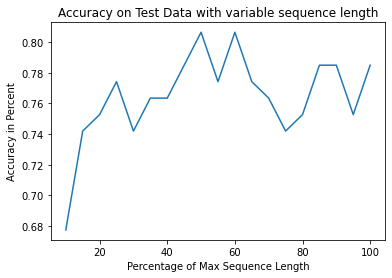

In [79]:
plt.plot(seq_percent,accuracy)
plt.title('Accuracy on Test Data with variable sequence length')
plt.xlabel('Percentage of Max Sequence Length')
plt.ylabel('Accuracy in Percent')
plt.show()

In [51]:
### Label ratio in train and Test dataset

In [ ]:
count = 0
for i in train_dataset:
    if (i['labels'] == 0):
        count +=1
print(count)

In [ ]:
# train data ratio 1/(1+0)
192/(87+192)

In [ ]:
# val data ratio 1/(1+0)
60/(60+33)

In [ ]:
# test data ratio 1/(1+0)
55/(55+38)